In [1]:
## Inspect Environment
## RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 68.7 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
!pip install librosa
!pip install pydub # for TF Dataset loading

In [231]:
import os
import time
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [36]:
# Librosa (the mother of audio files)
import librosa
import librosa.display
import IPython.display as ipd

In [7]:
print(tf.__version__)

2.7.0


## Load Data (From TF DataSet)

In [5]:
gtzan_data = tfds.load('gtzan') # 'Train'

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/gtzan/1.0.0.incompleteEVFN9J/gtzan-train.tfrecord


  0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset gtzan downloaded and prepared to /root/tensorflow_datasets/gtzan/1.0.0. Subsequent calls will reuse this data.


In [6]:
data = gtzan_data['train']

In [7]:
# gtzan_df = pd.DataFrame(gtzan_data)
# gtzan_df.head()
tfds.as_dataframe(gtzan_data['train'].take(5))

audio  ... label
0  [-8821, -8083, -6088, -4457, -2639, -1991, -50...  ...     7
1  [-170, -237, -81, 37, -8, 3, 146, 299, 466, 45...  ...     1
2  [-3789, -1596, -925, -1706, -1270, 393, 2340, ...  ...     6
3  [-3236, -2939, -343, -286, -600, 1869, 2548, -...  ...     9
4  [-353, -656, -795, -960, -821, -502, -250, 27,...  ...     1

[5 rows x 3 columns]

In [13]:
for sample in data.take(2):
  print(type(sample))
  audio_tensor = sample['audio']
  print(audio_tensor)
  ## Audio Display
  ipd.Audio(audio_tensor.numpy(), rate=3000)

<class 'dict'>
tf.Tensor([-8821 -8083 -6088 ...   417   -98  -489], shape=(661504,), dtype=int64)
<class 'dict'>
tf.Tensor([-170 -237  -81 ...  412  -27 -365], shape=(661794,), dtype=int64)


In [21]:
data_list = list(data.as_numpy_iterator())

In [22]:
[a['audio/filename'] for a in data_list[:10]]

[b'pop.00038.wav',
 b'classical.00013.wav',
 b'metal.00093.wav',
 b'rock.00074.wav',
 b'classical.00004.wav',
 b'classical.00009.wav',
 b'country.00089.wav',
 b'rock.00063.wav',
 b'metal.00012.wav',
 b'hiphop.00076.wav']

In [28]:
sample = data_list[9]
print(sample['audio/filename'])
ipd.Audio(sample['audio'], rate=22050)

b'hiphop.00076.wav'


## Load Data (From Local)

In [28]:
data_path = "GENERATIVE_DATA/GTZAN/genres_original/"

In [54]:
# DEV Test Loading file
sample, sample_rate = librosa.load(data_path+'hiphop/hiphop.00072.wav')
print("Sample Signal Shape: {}, sample Rate: {}".format(sample.shape, sample_rate))
ipd.Audio(sample, rate=22050)

Sample Signal Shape: (661794,), sample Rate: 22050


#### Samples Reproduce

In [55]:
"""
@description: Method to split a song into multiple songs using overlapping windows
"""
def splitsongs(X, y, window = 0.05, overlap = 0.5):
    # Empty lists to hold our results
    temp_X = []
    temp_y = []

    # Get the input song array size
    xshape = X.shape[0] # signal length
    chunk = int(xshape*window)
    offset = int(chunk*(1.-overlap))
    
    # Split the song and create new ones on windows
    spsong = [X[i:i+chunk] for i in range(0, xshape - chunk + offset, offset)]
    for s in spsong:
        # ignore the boundaries
        if s.shape[0] != chunk:
            continue

        temp_X.append(s)
        temp_y.append(y)

    return np.array(temp_X), np.array(temp_y)

In [56]:
## DEV
(sample_splits, sample_y_splits) = splitsongs(sample, 'hiphop', window=0.1) # break into 3s interval
print([s.shape for s in sample_splits])
print(sample_y_splits.shape)

[(66179,), (66179,), (66179,), (66179,), (66179,), (66179,), (66179,), (66179,), (66179,), (66179,), (66179,), (66179,), (66179,), (66179,), (66179,), (66179,), (66179,), (66179,), (66179,)]
(19,)


In [64]:
ipd.Audio(sample_splits[0], rate=sample_rate)

#### Convertsion to Spectragram (frequence heat map over time series)

In [58]:
"""
@description: Method to convert a list of songs to a np array of melspectrograms
@param hop_length: # samples between time frames; decide the dimension of 1-axis/time-axis length
"""
def to_melspectrogram(songs, n_fft=1024, hop_length=256):
    # Transformation function

    # add an axis to input sets
    # Adding Channel dimension; e.g. (28, 28) -> (28, 28, 1)
    melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
        hop_length=hop_length, n_mels=128)[:,:,np.newaxis]

    # map transformation of input songs to melspectrogram using log-scale
    tsongs = map(melspec, songs)
    # np.array([librosa.power_to_db(s, ref=np.max) for s in list(tsongs)])
    return np.array(list(tsongs))

In [81]:
sample_mel_specs = to_melspectrogram(sample_splits, hop_length=512, n_fft=2048)
print(sample_mel_specs.shape)

(19, 128, 130, 1)


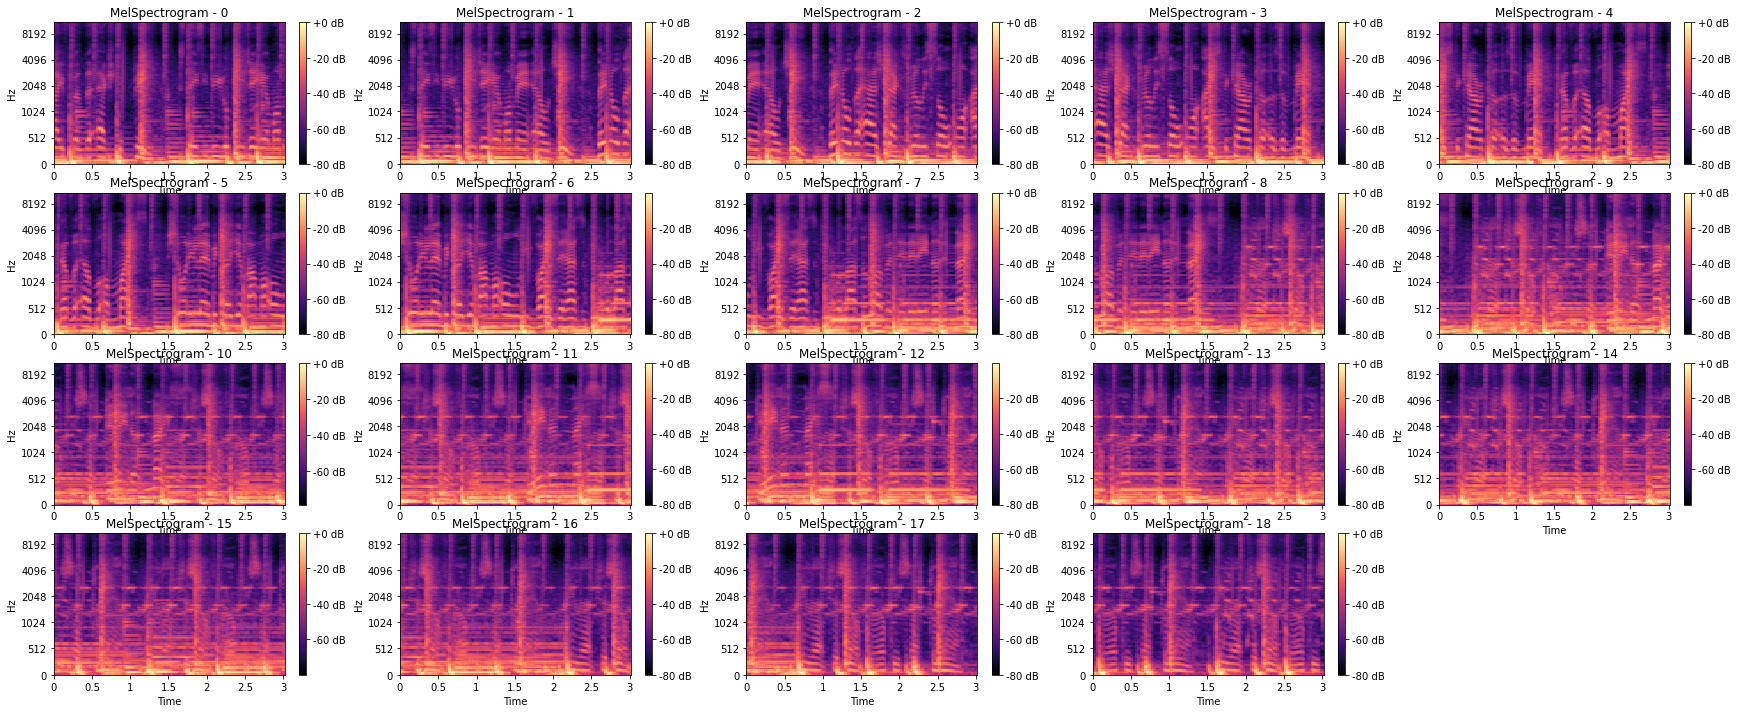

In [82]:
fig = plt.figure(figsize=(30, 12))

for i in range(sample_mel_specs.shape[0]):
  mel_spec_dB = librosa.power_to_db(sample_mel_specs[i].squeeze(), ref=np.max)
  plt.subplot(4, 5, i + 1)
  # plt.figure(figsize=(6, 3))
  librosa.display.specshow(mel_spec_dB, x_axis='time', y_axis='mel', sr=sample_rate)
  plt.colorbar(format='%+1.0f dB')
  plt.title(f"MelSpectrogram - {i}")
  # plt.tight_layout()
  
plt.show()

#### Spectragram to Signal

In [117]:

def mel_to_audio(mel_spec, sample_rate=22050):
  sample_signal_inverse = librosa.feature.inverse.mel_to_audio(mel_spec, hop_length=512)
  return sample_signal_inverse

In [119]:
  ipd.Audio(mel_to_audio(sample_mel_specs[0].squeeze()), rate=sample_rate)

## Data Preprocessing

In [107]:
''' 
  1. Split each single 30s song sample into smaller segment
  2. convert each segment to melspectrogram
'''
def split_convert(X, y, max_signal_len=660000):
    arr_specs, arr_genres = [], []
    
    # Convert to spectrograms and split into small windows
    for fn, genre in zip(X, y):
        # for debug
        print(f"Loading audio file: {fn}...")

        signal, sr = librosa.load(fn)
        # to avoid inconsistent image/spectragram size
        signal = signal[:max_signal_len]

        # Convert to dataset of spectograms/melspectograms
        signals, y = splitsongs(signal, genre, window=0.1)

        # Convert to "spec" representation
        specs = to_melspectrogram(signals, hop_length=512, n_fft=2048)

        # Save files
        ## attach the forked list of sample segments
        arr_genres.extend(y)
        arr_specs.extend(specs)
    
    return np.array(arr_specs), np.array(arr_genres)

'''
 Generate data-set based on file_path for each audio sample
- then preprocess and convert each sample accordingly
'''
def read_data(src_dir, genres, max_signal_len=660000):    
    # Empty array of dicts with the processed features from all files
    arr_fn = []
    arr_genres = []

    # Get file list from the folders
    for x,_ in genres.items():
        folder = src_dir + x
        print(f"Loading Audio files under Genere: {x}")
        for root, subdirs, files in os.walk(folder):
            for file in files:
                file_name = folder + "/" + file

                ### TODO: some samples just don't load...
                if file_name.find('jazz/jazz.00054.wav') != -1:
                  print(f"Skipping file: {file_name}...")
                  continue

                # Save the file name and the genre
                arr_fn.append(file_name)
                # attach the label
                arr_genres.append(genres[x])
    
    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        arr_fn, arr_genres, test_size=0.2, random_state=42, stratify=arr_genres #data is split in a stratified fashion under genre label
    )
    
    # Split into small segments and convert to spectrogram
    ## TODO: map this to TF DataSet process
    print("Loading and Preprocessing Training data......")
    X_train, y_train = split_convert(X_train, y_train, max_signal_len=max_signal_len)
    print("Loading and Preprocessing Testing data......")
    X_test, y_test = split_convert(X_test, y_test, max_signal_len=max_signal_len)

    return X_train, y_train, X_test, y_test

In [ ]:
## Data Loading
MAX_SIGNAL_LEN = 660000
genres = {'metal': 0, 'disco': 1, 'classical': 2, 'rock': 3, 'jazz': 4, 
          'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'hiphop': 9}

# Read the data
X_train, y_train, X_test, y_test = read_data(data_path, genres, max_signal_len=MAX_SIGNAL_LEN)

In [159]:
idx_to_genres = {v:k for (k, v) in genres.items()}
idx_to_genres

{0: 'metal',
 1: 'disco',
 2: 'classical',
 3: 'rock',
 4: 'jazz',
 5: 'country',
 6: 'pop',
 7: 'blues',
 8: 'reggae',
 9: 'hiphop'}

In [124]:
# print(type(X_train), len(X_train), len(X_test))
print(type(X_train), X_train.shape, X_test.shape, y_train.shape, X_test.shape)

print(y_train[:5])
print(set(y_train), set(y_test))

<class 'numpy.ndarray'> (15181, 128, 129, 1) (3800, 128, 129, 1) (15181,) (3800, 128, 129, 1)
[5 5 5 5 5]
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9} {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [123]:
## Debug Inspect samples
hiphop_idx = np.where(y_train==9)[0]
print(hiphop_idx)
ipd.Audio(mel_to_audio(X_train[hiphop_idx[2]].squeeze()), rate=sample_rate)

[   38    39    40 ... 15121 15122 15123]


###### Data Normalization

In [400]:
MAX_SPEC = max(np.amax(X_train), np.amax(X_test))
MIN_SPEC = min(np.amin(X_train), np.amin(X_test))
print(MAX_SPEC, MIN_SPEC)

11115.553 0.0


In [409]:
X_train_scaled = X_train / MAX_SPEC
X_test_scaled = X_test / MAX_SPEC

In [407]:
print(X_train_scaled[0].squeeze())
print(np.amin(X_train_scaled), np.amax(X_train_scaled))

[[2.4615714e-04 6.8862304e-05 9.0249396e-06 ... 4.2094560e-03
  4.0268898e-03 3.9056637e-03]
 [9.2019310e-04 3.2642891e-04 1.3157901e-04 ... 9.5433546e-03
  8.5687647e-03 7.9298196e-03]
 [7.8792404e-03 6.6686356e-03 6.4592175e-03 ... 1.6004901e-02
  1.5722904e-02 1.5822252e-02]
 ...
 [1.8934500e-08 4.7363495e-09 2.4065402e-12 ... 5.3733723e-12
  6.4343474e-12 2.4204019e-09]
 [1.8045274e-08 4.5117909e-09 5.7873064e-13 ... 1.1360965e-12
  1.2311981e-12 2.4786473e-09]
 [1.7327649e-08 4.3320689e-09 3.8142203e-13 ... 4.3551179e-13
  6.1314750e-13 2.4875504e-09]]
0.0 1.0


## CONSTANT DEF

In [170]:
BATCH_SIZE = 32
TRAIN_SHUFFLE_SIZE = 16000
NUM_GENERES = len(np.unique(y_train))

EPOCHS = 10
# set the dimensionality of the latent space to a plane for visualization later
LATENT_DIM = 2

In [410]:
## Load to TF DataSet (numpy to TF Tensor)
# train_dataset = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
#                  .shuffle(TRAIN_SHUFFLE_SIZE)
#                  .batch(BATCH_SIZE))
# test_dataset = (tf.data.Dataset.from_tensor_slices((X_test, y_test))
#                  .batch(BATCH_SIZE))

train_dataset = (tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train))
                 .shuffle(TRAIN_SHUFFLE_SIZE)
                 .batch(BATCH_SIZE))
test_dataset = (tf.data.Dataset.from_tensor_slices((X_test_scaled, y_test))
                 .batch(BATCH_SIZE))

In [419]:
## Debug
test_batch = next(iter(train_dataset))
print(len(test_batch))
print(test_batch[0].shape, test_batch[1].shape)
print(test_batch[1])

hiphop_idx = np.where(test_batch[1]==9)[0]
print(hiphop_idx)
audio = test_batch[0][hiphop_idx[0]].numpy().squeeze()
print(audio, audio.shape)
ipd.Audio(mel_to_audio(audio * MAX_SPEC), rate=sample_rate)

2
(32, 128, 129, 1) (32,)
tf.Tensor([0 3 4 1 3 1 2 9 0 3 1 3 2 3 2 5 3 3 8 8 3 9 5 9 4 9 2 7 6 9 8 0], shape=(32,), dtype=int32)
[ 7 21 23 25 29]
[[7.3273913e-03 4.1253823e-03 1.4557581e-03 ... 1.7708444e-05
  1.7590623e-05 1.6489961e-05]
 [2.2585563e-02 1.8932978e-02 5.4398049e-03 ... 3.2847398e-04
  2.4696224e-04 3.9674422e-05]
 [3.0101691e-03 5.8746045e-03 1.6394863e-03 ... 2.8308007e-04
  2.6419788e-04 4.0351355e-05]
 ...
 [5.3146927e-09 2.2163027e-09 6.6438932e-10 ... 3.8088865e-09
  2.8046263e-09 3.1495546e-09]
 [2.4371638e-09 6.3030881e-10 2.4696222e-11 ... 5.3889904e-10
  1.6653362e-10 2.6006819e-10]
 [2.0308786e-09 5.0831545e-10 8.6325131e-13 ... 4.7590495e-12
  3.3025184e-12 1.2631066e-10]] (128, 129)


In [283]:
## Debug: value of Mel Spectragram
tf.reduce_min(test_batch[0])

<tf.Tensor: shape=(), dtype=float32, numpy=2.851289e-09>

#### A group of test data set (3 x 3) for validation/performance inspeculation

In [422]:
# create a dict of each unique entry and the associated indices
generes_test_idx = {v: np.where(y_test == v)[0].tolist()[:6] for v in np.unique(y_test)}

print(generes_test_idx)

val_samples = []

for i in range(NUM_GENERES):
  val_samples.append(X_test_scaled[int(generes_test_idx[i][0])])

# Numpy Array
val_samples = np.stack(val_samples, axis=0)

{0: [19, 20, 21, 22, 23, 24], 1: [0, 1, 2, 3, 4, 5], 2: [95, 96, 97, 98, 99, 100], 3: [285, 286, 287, 288, 289, 290], 4: [152, 153, 154, 155, 156, 157], 5: [57, 58, 59, 60, 61, 62], 6: [38, 39, 40, 41, 42, 43], 7: [494, 495, 496, 497, 498, 499], 8: [228, 229, 230, 231, 232, 233], 9: [114, 115, 116, 117, 118, 119]}


In [425]:
val_samples.shape
print(np.amax(val_samples))

0.4922854


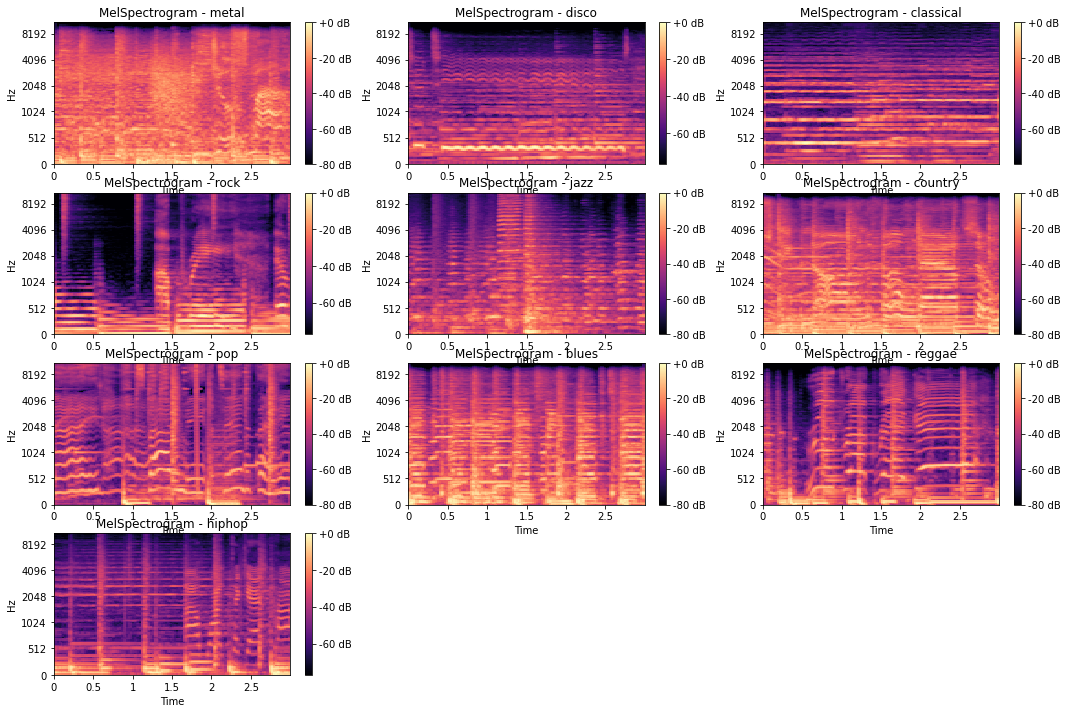

In [426]:
fig = plt.figure(figsize=(18, 12))

for i in range(val_samples.shape[0]):
  mel_spec_dB = librosa.power_to_db(val_samples[i].squeeze(), ref=np.max)
  plt.subplot(4, 3, i + 1)
  # plt.figure(figsize=(6, 3))
  librosa.display.specshow(mel_spec_dB, x_axis='time', y_axis='mel', sr=sample_rate)
  plt.colorbar(format='%+1.0f dB')
  plt.title(f"MelSpectrogram - {idx_to_genres[i]}")
  # plt.tight_layout()
  
plt.show()

In [427]:
ipd.Audio(mel_to_audio(val_samples[3].squeeze()), rate=sample_rate)

In [428]:
# Scaled Back
ipd.Audio(mel_to_audio(val_samples[3].squeeze() * MAX_SPEC), rate=sample_rate)

In [164]:
ipd.Audio(mel_to_audio(val_samples[4].squeeze()), rate=sample_rate)

## Model Structure

#### Vanila Variational Auto-Encoder (VAE) with Convolution

In [429]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim, input_img_shape=(28, 29, 1)):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=input_img_shape),
            tf.keras.layers.Conv2D(
                filters=16, kernel_size=2, strides=(2, 2), activation='relu', padding='valid'),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu', padding='same'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu', padding='same'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu', padding='same'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=8*8*64, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(8, 8, 64)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=16, kernel_size=2, strides=2, padding='valid',
                activation='relu'),
            # No activation
            # temporary trick here to reshape back to input size
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=(1, 2), strides=1, padding='valid'),
        ]
    )

  '''
    Inference function, sample latent z of size 100 from N(0, I) if not provided
  '''
  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    # $$$$ sample the stochastic epsilon
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [430]:
input_shape = test_batch[0].shape[1:]
print(input_shape)
test_model = CVAE(LATENT_DIM, input_img_shape = input_shape)

(128, 129, 1)


In [431]:
test_model.encoder.summary()
test_model.decoder.summary()

Model: "sequential_92"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_110 (Conv2D)         (None, 64, 64, 16)        80        
                                                                 
 conv2d_111 (Conv2D)         (None, 32, 32, 32)        4640      
                                                                 
 conv2d_112 (Conv2D)         (None, 16, 16, 64)        18496     
                                                                 
 conv2d_113 (Conv2D)         (None, 8, 8, 64)          36928     
                                                                 
 flatten_46 (Flatten)        (None, 4096)              0         
                                                                 
 dense_92 (Dense)            (None, 4)                 16388     
                                                                 
Total params: 76,532
Trainable params: 76,532
Non-tra

In [432]:
## Encoder forward pass
test_enc_out = test_model.encode(test_batch[0])
print(test_enc_out[0].shape, test_enc_out[1].shape) # (B, L), (B, L)

(32, 2) (32, 2)


In [433]:
## Decoder forward pass
test_z = test_model.reparameterize(test_enc_out[0], test_enc_out[1])
test_dec_out = test_model.decode(test_z)
print(test_dec_out.shape)
print(test_dec_out[0].numpy().squeeze())

(32, 128, 129, 1)
[[-1.14290473e-04 -2.07589997e-04  1.23568272e-04 ... -1.03549173e-04
  -2.13335923e-04 -1.82459698e-04]
 [-1.56381444e-04  6.99828815e-05  5.50609802e-05 ... -1.28381886e-04
  -1.06861036e-04 -5.50492950e-05]
 [ 4.29426800e-05 -4.97650472e-04 -3.97033815e-04 ... -5.89148432e-04
  -9.28411027e-04 -3.74453492e-04]
 ...
 [-5.31598576e-04 -2.49193865e-04 -8.58505955e-05 ... -9.87696811e-04
  -2.42941038e-04 -1.24502621e-04]
 [-1.05082283e-04 -3.57025827e-04 -4.27304098e-04 ... -3.97198688e-04
  -5.44577255e-04 -1.85097277e-04]
 [-3.00955962e-05 -1.89368817e-04 -1.39924945e-04 ... -2.92782381e-04
   7.80807168e-05 -4.02541227e-05]]


In [434]:
## MSE Loss
mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
print(test_batch[0].shape, test_dec_out.shape)
test_loss = mse(test_batch[0], test_dec_out)
print(test_loss.shape)
print(tf.reduce_sum(test_loss, axis=[1, 2]))
print(tf.reduce_mean(tf.reduce_sum(test_loss, axis=[1, 2]))) # (B, )
print(tf.reduce_mean(test_loss)) # (B, )

(32, 128, 129, 1) (32, 128, 129, 1)
(32, 128, 129)
tf.Tensor(
[3.0150015e-02 4.2020809e-02 5.0596547e-01 2.6316541e-01 2.0454702e-01
 4.9208868e-02 6.7100329e-03 5.5749136e-01 3.1117814e-02 3.4585601e-01
 9.6727028e-02 7.5438008e-02 1.4775788e-03 8.1440331e-03 2.1150392e-03
 6.2768072e-02 3.2774065e-02 3.3466827e-02 3.0481222e-01 9.1094859e-02
 2.6679140e-02 1.6558348e+00 3.1501021e-02 1.0438542e-01 9.6153412e-03
 2.2452173e+00 7.5543761e-02 2.4023952e-01 2.8655794e-01 9.6001345e-01
 9.8142751e-02 1.1075043e-01], shape=(32,), dtype=float32)
tf.Tensor(0.26842287, shape=(), dtype=float32)
tf.Tensor(1.625623e-05, shape=(), dtype=float32)


#### VAE: Loss Function and Optimization/Learning

In [435]:
## DEV
# Using 'none' reduction type.
y_true = [[0., 3.], [0., 0.]]
y_pred = [[1., 1.], [1., 0.]]
mse_ = tf.keras.losses.MeanSquaredError(
    reduction=tf.keras.losses.Reduction.NONE)
mse_(y_true, y_pred).numpy()

array([2.5, 0.5], dtype=float32)

In [490]:
# optimizer = tf.keras.optimizers.Adam()

'''
log(x)
x ~ N(x; u, sigma^2)
'''
def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  # x(x==1)logp(x'|z) 
  # note that data is already binarized
  # cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  ## TODO: Under MSE, is this still cross_ent?
  mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
  cross_ent = mse(y_true=x, y_pred=x_logit)
  # keep the error for each instance within batch: (B, )
  # logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2])
  # mse_loss = tf.reduce_mean(tf.reduce_sum(cross_ent, axis=[1,2]))

  # per pixel...
  mse_loss = tf.reduce_mean(cross_ent)

  # print("Batch level Reconstruction Error: ", logpx_z.shape)
  logpz = log_normal_pdf(z, 0., 0.) # log1 = 0
  logqz_x = log_normal_pdf(z, mean, logvar)
  # DEBUG
  print(f"logqz_x: {logqz_x},  logpz: {logpz}")
  print(f"avg logqz_x: {tf.reduce_mean(logqz_x)}, avg logpz: {-tf.reduce_mean(logpz)}")
  # -ELBO to minimize
  KL_approx = -tf.reduce_mean(logpz - logqz_x)
  print(f"MSE: {mse_loss}, KL: {KL_approx}")
  # return -tf.reduce_mean(logpx_z + logpz - logqz_x)
  return mse_loss + KL_approx


def compute_loss_(model, x):
  '''
  @param x: the input data
  '''
  # DEBUG
  # print(f"======= [DEBUG] This is the propoer KL based Loss Computation...")
  z_mean, z_log_var = model.encode(x)
  z = model.reparameterize(z_mean, z_log_var)
  reconstruction = model.decode(z) # Non-Activated Linear output: raw logits

  ## TODO: Under MSE, is this still cross_ent?
  # mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
  reconstruction_loss = tf.reduce_mean(
      # tf.reduce_sum(
      #     mse(x, reconstruction), axis=(1, 2) # sum up all pixles and average by instance
      # )
      # ENT
      tf.reduce_sum(
          tf.keras.losses.binary_crossentropy(x, reconstruction, from_logits=True), axis=(1,2)
      )

      # mse(y_true=x, y_pred=reconstruction)
  )
  kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
  kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
  total_loss = reconstruction_loss + kl_loss

  # print(f"Reconstruction Loss/MSE: {reconstruction_loss}, KL: {kl_loss}")

  return total_loss

@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss_(model, x)
    # print(f"Training Loss to Back Prop: {loss}")
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  return loss

In [491]:
#### Validation between Epoches
'''
 sample latent z based on actual test data x
'''
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  # print('(Test Image generation) Epoch: {}, encoded mean: {}, encoded log var: {}'.format(epoch, mean, logvar))
  z = model.reparameterize(mean, logvar) # The actual sample happens here
  predictions = model.sample(z) # equals to directly decode here
  fig = plt.figure(figsize=(18, 12))

  for i in range(predictions.shape[0]):
    mel_spec_dB = librosa.power_to_db(predictions[i].numpy().squeeze(), ref=np.max)
    plt.subplot(4, 3, i + 1)
    # plt.figure(figsize=(6, 3))
    # print("MEL SPEC DB: {}".format(mel_spec_dB.shape))
    # print(mel_spec_dB)
    librosa.display.specshow(mel_spec_dB, x_axis='time', y_axis='mel', sr=sample_rate)
    plt.colorbar(format='%+1.0f dB')
    plt.title(f"MelSpectrogram - {idx_to_genres[i]}")
    # plt.tight_layout()
    
  plt.show()

In [492]:
# del optimizer
# optimizer

## Training&&Validation Steps

In [493]:
input_shape = test_batch[0].shape[1:]
print(input_shape)
model = CVAE(128, input_img_shape=input_shape)
model.encoder.summary()
model.decoder.summary()

(128, 129, 1)
Model: "sequential_110"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_146 (Conv2D)         (None, 64, 64, 16)        80        
                                                                 
 conv2d_147 (Conv2D)         (None, 32, 32, 32)        4640      
                                                                 
 conv2d_148 (Conv2D)         (None, 16, 16, 64)        18496     
                                                                 
 conv2d_149 (Conv2D)         (None, 8, 8, 64)          36928     
                                                                 
 flatten_55 (Flatten)        (None, 4096)              0         
                                                                 
 dense_110 (Dense)           (None, 256)               1048832   
                                                                 
Total params: 1,108,976
Trainable para

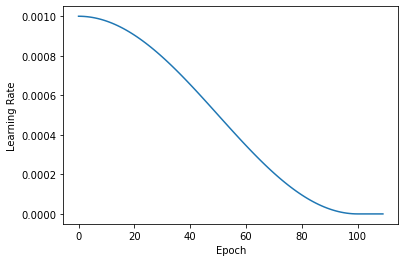

In [494]:
del optimizer
decay_steps = 100
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
    1e-3, decay_steps, alpha=1e-4)

plt.plot(range(decay_steps+10), lr_decayed_fn(range(decay_steps+10)))
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')

# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_decayed_fn)
optimizer = tf.keras.optimizers.Adam()

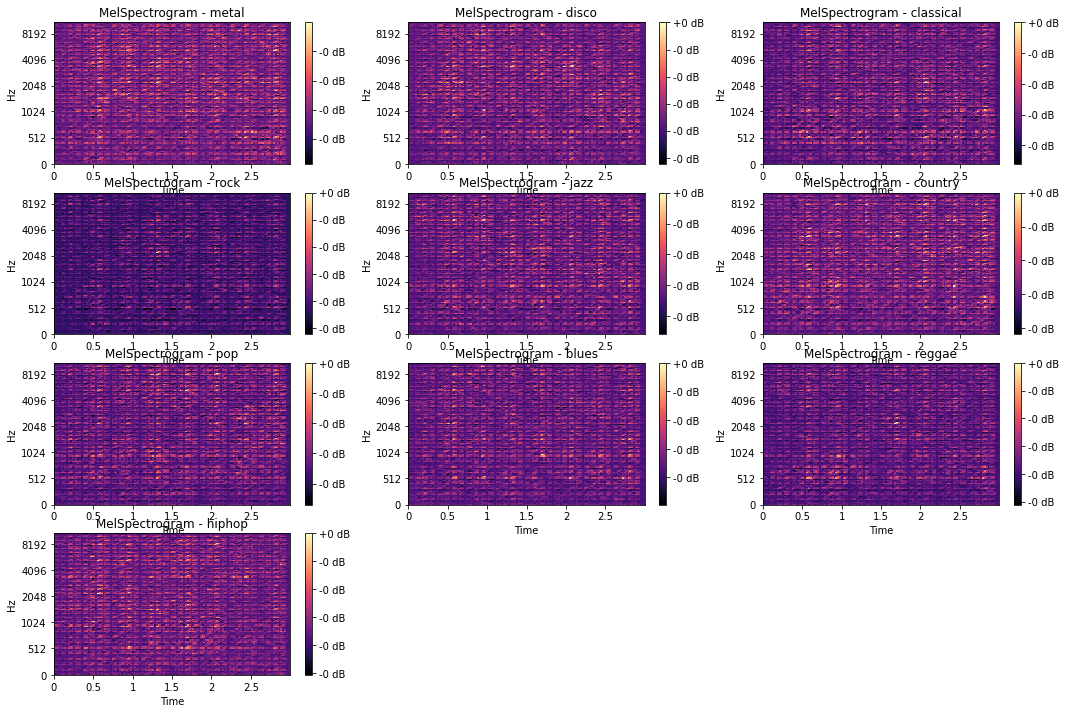

========= Epoch:1 Batch:0, Train Loss for minimization: 11479.849609375, time elapse for current epoch: 1.0360019207000732
========= Epoch:1 Batch:50, Train Loss for minimization: 123.53103637695312, time elapse for current epoch: 1.7369709014892578
========= Epoch:1 Batch:100, Train Loss for minimization: 91.56114196777344, time elapse for current epoch: 2.4109997749328613
========= Epoch:1 Batch:150, Train Loss for minimization: 68.94429016113281, time elapse for current epoch: 3.0899713039398193
========= Epoch:1 Batch:200, Train Loss for minimization: 68.22477722167969, time elapse for current epoch: 3.756971597671509
========= Epoch:1 Batch:250, Train Loss for minimization: 62.836544036865234, time elapse for current epoch: 4.435001611709595
========= Epoch:1 Batch:300, Train Loss for minimization: 72.57076263427734, time elapse for current epoch: 5.100003957748413
========= Epoch:1 Batch:350, Train Loss for minimization: 70.39898681640625, time elapse for current epoch: 5.7700004

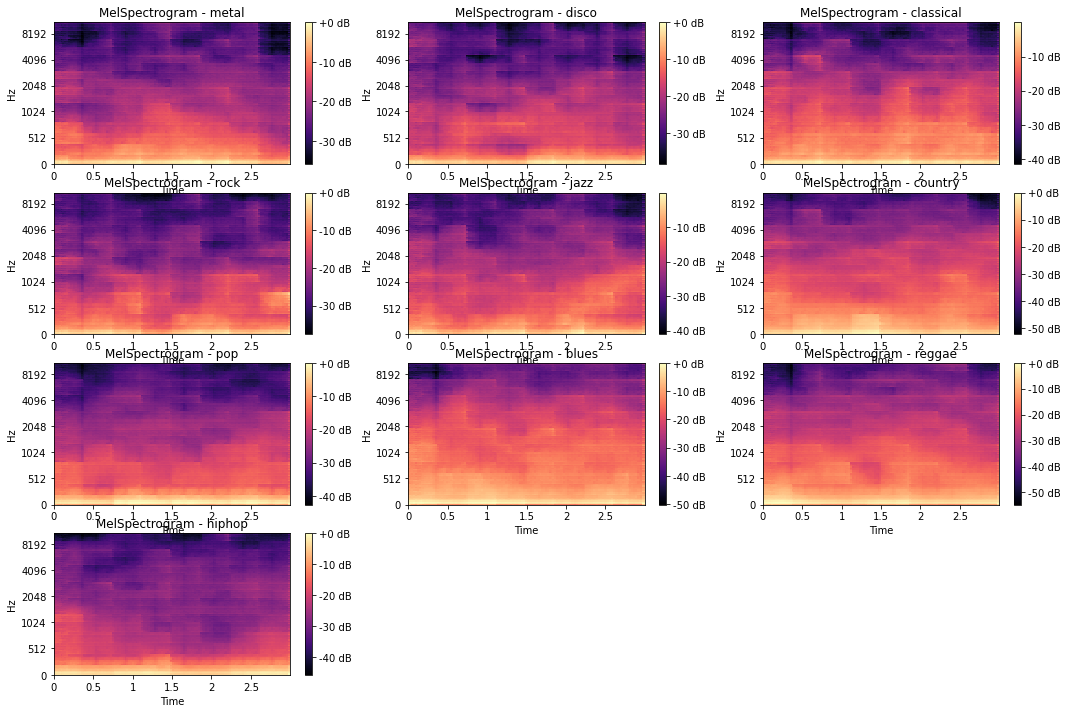

========= Epoch:6 Batch:0, Train Loss for minimization: 57.065582275390625, time elapse for current epoch: 0.40203046798706055
========= Epoch:6 Batch:50, Train Loss for minimization: 46.0308952331543, time elapse for current epoch: 1.1680006980895996
========= Epoch:6 Batch:100, Train Loss for minimization: 54.26871871948242, time elapse for current epoch: 1.8150293827056885
========= Epoch:6 Batch:150, Train Loss for minimization: 60.008506774902344, time elapse for current epoch: 2.4680304527282715
========= Epoch:6 Batch:200, Train Loss for minimization: 53.01017379760742, time elapse for current epoch: 3.1220221519470215
========= Epoch:6 Batch:250, Train Loss for minimization: 55.885746002197266, time elapse for current epoch: 3.775028705596924
========= Epoch:6 Batch:300, Train Loss for minimization: 54.08631896972656, time elapse for current epoch: 4.431028604507446
========= Epoch:6 Batch:350, Train Loss for minimization: 57.085304260253906, time elapse for current epoch: 5.08

In [ ]:
val_loss_history = []
train_loss_history = []


generate_and_save_images(model, 0, val_samples)

for epoch in range(1, 100):
  start_time = time.time()
  for (step, (train_x, train_y)) in enumerate(train_dataset):
    # print(train_x.shape, train_y.shape)
    train_loss = train_step(model, train_x, optimizer)
    train_loss_history.append(train_loss)

    if step%50 == 0:

      print('========= Epoch:{} Batch:{}, Train Loss for minimization: {}, time elapse for current epoch: {}'
        .format(epoch, step, train_loss, time.time() - start_time))
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x, test_y in test_dataset:
    loss(compute_loss_(model, test_x))
  
  val_loss_history.append(loss.result())
  elbo = -loss.result()
  # display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}/Loss for minimization: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, loss.result(), end_time - start_time))
  
  if epoch % 5 == 0:
    generate_and_save_images(model, epoch, val_samples)

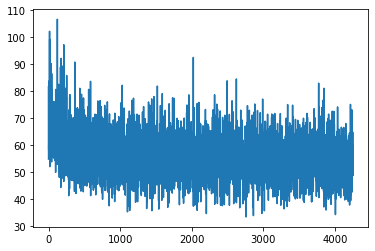

In [467]:
# train_loss_history
plt.plot(train_loss_history[500:], label="Training Loss")


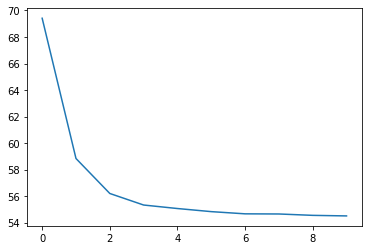

In [466]:
plt.plot(val_loss_history, label="Training Loss")
